In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import seaborn as sns
import os
import sqlite3

# Preprocessing
#from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor, GradientBoostingRegressor, StackingRegressor, RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, cross_validate
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler

# Model
from sklearn.dummy import DummyRegressor
from xgboost import XGBRegressor
import optuna
import shap
import joblib
import keras

from scripts.config import DATA_PATH, MODELS_PATH

%load_ext autoreload
%autoreload 2

%load_ext tensorboard

from tempfile import mkdtemp
# Create a temp folder
cachedir = mkdtemp()

2025-08-21 21:38:43.599324: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-08-21 21:38:43.600443: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-21 21:38:43.603863: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-08-21 21:38:43.610581: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755805123.622815  127071 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755805123.62

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


/home/ronan/code/Power_Price_Forecasting/scripts/preprocess_att.py:707: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['Month'] = df['datetime'].dt.to_period('M')


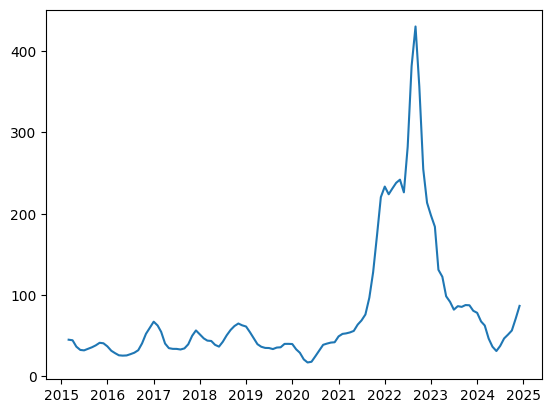

In [2]:
model_data = pd.read_csv(os.path.join(DATA_PATH, 'ATT', 'model_data.csv'))

from scripts.preprocess_att import monthly_statistics

monthly_stats = monthly_statistics(model_data)

plt.plot(monthly_stats.index, monthly_stats['3-Month Rolling Average'])

# 1. Import processed data

In [3]:
X_past_train = np.load(os.path.join(DATA_PATH, 'ATT', 'X_past_train.npy'))
X_future_train = np.load(os.path.join(DATA_PATH, 'ATT', 'X_future_train.npy'))
X_past_val = np.load(os.path.join(DATA_PATH, 'ATT', 'X_past_val.npy'))
X_future_val = np.load(os.path.join(DATA_PATH, 'ATT', 'X_future_val.npy'))
X_past_test = np.load(os.path.join(DATA_PATH, 'ATT', 'X_past_test.npy'))
X_future_test = np.load(os.path.join(DATA_PATH, 'ATT', 'X_future_test.npy'))

X_past_train_transformed = np.load(os.path.join(DATA_PATH, 'ATT', 'X_past_train_transformed.npy'))
X_future_train_transformed = np.load(os.path.join(DATA_PATH, 'ATT', 'X_future_train_transformed.npy'))
X_past_val_transformed = np.load(os.path.join(DATA_PATH, 'ATT', 'X_past_val_transformed.npy'))
X_future_val_transformed = np.load(os.path.join(DATA_PATH, 'ATT', 'X_future_val_transformed.npy'))
X_past_test_transformed = np.load(os.path.join(DATA_PATH, 'ATT', 'X_past_test_transformed.npy'))
X_future_test_transformed = np.load(os.path.join(DATA_PATH, 'ATT', 'X_future_test_transformed.npy'))
y_train = np.load(os.path.join(DATA_PATH, 'ATT', 'y_train.npy'))
y_val = np.load(os.path.join(DATA_PATH, 'ATT', 'y_val.npy'))
y_test = np.load(os.path.join(DATA_PATH, 'ATT', 'y_test.npy'))

train_past_times = pd.read_pickle(os.path.join(DATA_PATH, 'ATT', 'train_past_times.pkl'))
train_future_times = pd.read_pickle(os.path.join(DATA_PATH, 'ATT', 'train_future_times.pkl'))
val_past_times = pd.read_pickle(os.path.join(DATA_PATH, 'ATT', 'val_past_times.pkl'))
val_future_times = pd.read_pickle(os.path.join(DATA_PATH, 'ATT', 'val_future_times.pkl'))
test_past_times = pd.read_pickle(os.path.join(DATA_PATH, 'ATT', 'test_past_times.pkl'))
test_future_times = pd.read_pickle(os.path.join(DATA_PATH, 'ATT', 'test_future_times.pkl'))



In [4]:
from scripts.preprocess_att import shuffle_data, merge_data, split_data

data_train = merge_data(X_past_train_transformed, X_future_train_transformed, y_train, train_past_times, train_future_times)
data_val = merge_data(X_past_val_transformed, X_future_val_transformed, y_val, val_past_times, val_future_times)
data_test = merge_data(X_past_test_transformed, X_future_test_transformed, y_test, test_past_times, test_future_times)

data_train_new, data_val_new, data_test_new = shuffle_data(data_train, data_val, data_test)

X_past_train_transformed, X_future_train_transformed, y_train, train_past_times, train_future_times = split_data(data_train_new)
X_past_val_transformed, X_future_val_transformed, y_val, val_past_times, val_future_times = split_data(data_val_new)
X_past_test_transformed, X_future_test_transformed, y_test, test_past_times, test_future_times = split_data(data_test_new)

X_past_train.shape: (1101, 168, 21), X_past_val.shape: (367, 168, 21), X_past_test.shape: (347, 168, 21)

Data shuffling summary:
Total samples shuffled: 1,815
New training set size: 1,101
New validation set size: 367
New test set size: 347


# 2. Forecast with simple LSTM

In [5]:
from scripts.model_lstm import LSTMModel

lstm_model = LSTMModel(
    # LSTM parameters
    lstm_units=32,        # Good starting point: ~2-4x number of features
    dense_units=16,        # Half of LSTM units for dimensionality reduction

    # Input dimensions (from your data)
    n_past_features=X_past_train_transformed.shape[2],
    n_future_features=X_future_train_transformed.shape[2],
    past_seq_len=X_past_train_transformed.shape[1],
    future_seq_len=X_future_train_transformed.shape[1],

    # Regularization
    dropout=0.3,           # Moderate dropout to prevent overfitting
    batch_normalization=True,

    # Training parameters
    learning_rate=0.001,   # Standard learning rate for Adam
    verbose=True,
    epochs_early_stopping=20,

    # Loss and metrics
    loss='mse',
    metrics=['mae', 'mape'],

    # Additional regularization
    regularization='l2',
    lambda_reg=0.01       # Small L2 penalty
)

lstm_model

2025-08-21 21:38:47.755237: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/1000


2025-08-21 21:38:57.075862: E tensorflow/core/util/util.cc:131] oneDNN supports DT_INT32 only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


35/35 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 3503.7817 - mae: 51.1151 - mape: 3077929.2500 - val_loss: 3466.2874 - val_mae: 49.5551 - val_mape: 12850943.0000 - learning_rate: 0.0010
Epoch 2/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - loss: 3381.2964 - mae: 49.6582 - mape: 8653167.0000 - val_loss: 3380.8572 - val_mae: 49.0812 - val_mape: 7895328.0000 - learning_rate: 0.0010
Epoch 3/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 3210.1001 - mae: 49.0790 - mape: 8139832.0000 - val_loss: 3313.4399 - val_mae: 48.9368 - val_mape: 12205299.0000 - learning_rate: 0.0010
Epoch 4/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 2983.1045 - mae: 47.9317 - mape: 14128808.0000 - val_loss: 3265.0537 - val_mae: 49.0128 - val_mape: 15833385.0000 - learning_rate: 0.0010
Epoch 5/1000
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 3034.5288 - mae: 48.2705 - mape: 15510553.0000 - val_loss: 3221.8560 - val_mae: 49.2063 - val_mape: 29541574.0000 - learning_rate: 0.0010
Epoch 6/1000
35/35 ━━━

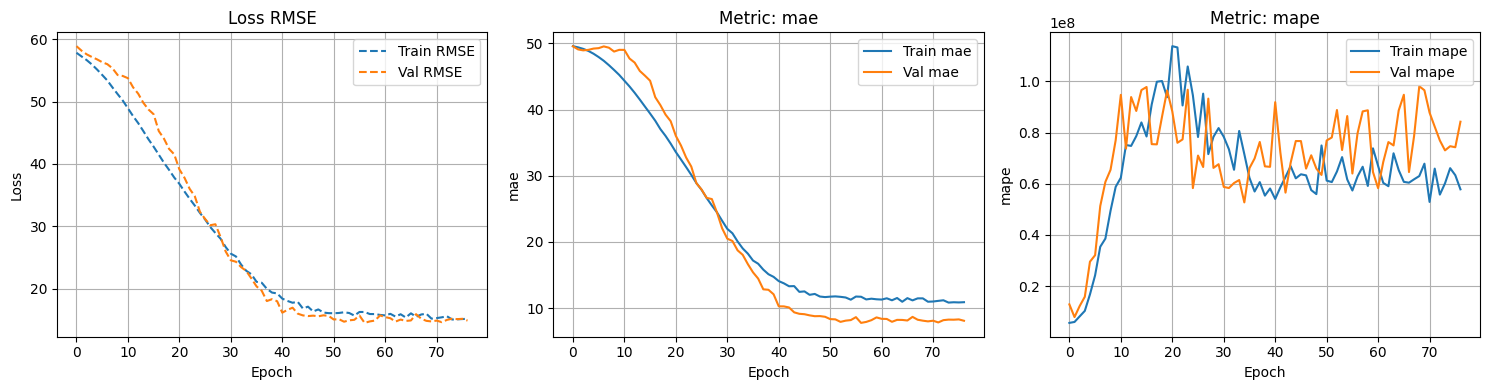

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 209.3484 - mae: 7.4752 - mape: 74554208.0000
35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 87.9760 - mae: 5.9711 - mape: 46393612.0000

Final Training Metrics:
RMSE: 9.2881
['mae', 'mape']: [5.981490135192871, 41609008.0]

Final Validation Metrics:
RMSE: 14.5336
['mae', 'mape']: [7.756501197814941, 79698520.0]


In [6]:
lstm_model.fit(X_past_train_transformed, X_future_train_transformed, y_train, 
            X_past_val_transformed, X_future_val_transformed, y_val)


In [ ]:
from scripts.config import LOGS_PATH
%tensorboard --logdir {LOGS_PATH}/LSTM/fit

Launching TensorBoard...

In [ ]:
test_results = lstm_model.model.evaluate(
            [X_past_test, X_future_test],
            y_test
        )

test_loss = np.sqrt(test_results[0])
test_metrics = test_results[1:]

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Metrics: {test_metrics}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 229311168512.0000 - mae: 471805.2812 - mape: 6265324437504.0000
Test Loss: 468742.0644
Test Metrics: [462161.71875, 8660107395072.0]


In [ ]:
from scripts.model_att import AttentionModel
model_name = "20250820-135126"

att_model = AttentionModel.from_saved_model(model_name)

att_model

KeyError: 'parameters'

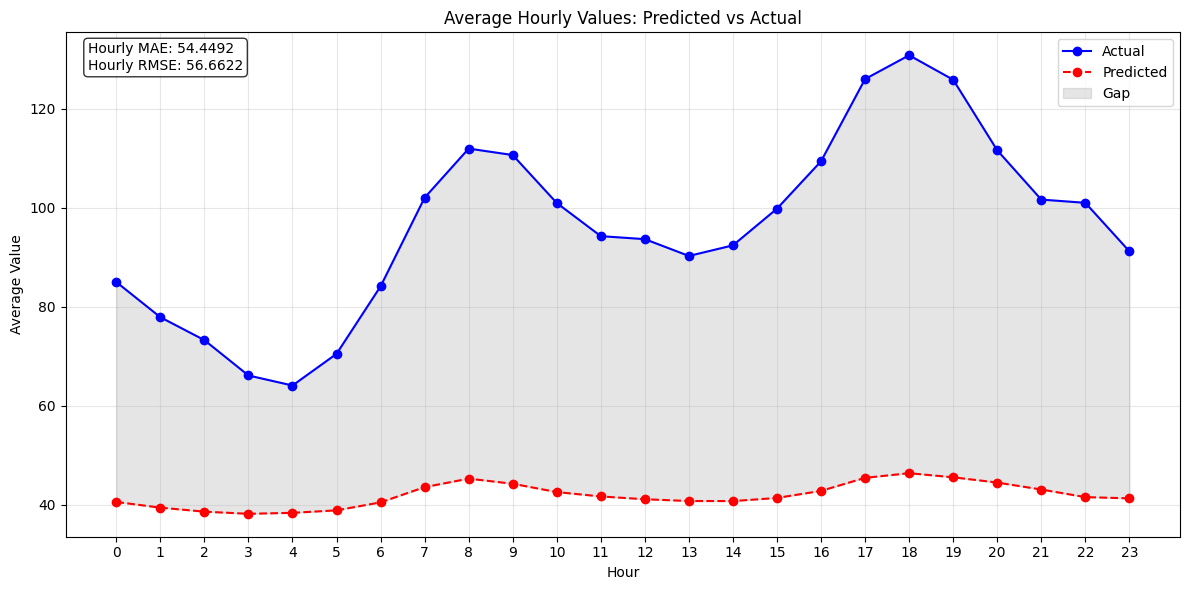

In [ ]:
pred = att_model.predict(X_past_test_transformed, X_future_test_transformed)

att_model.plot_hourly_averages(y_test, pred)

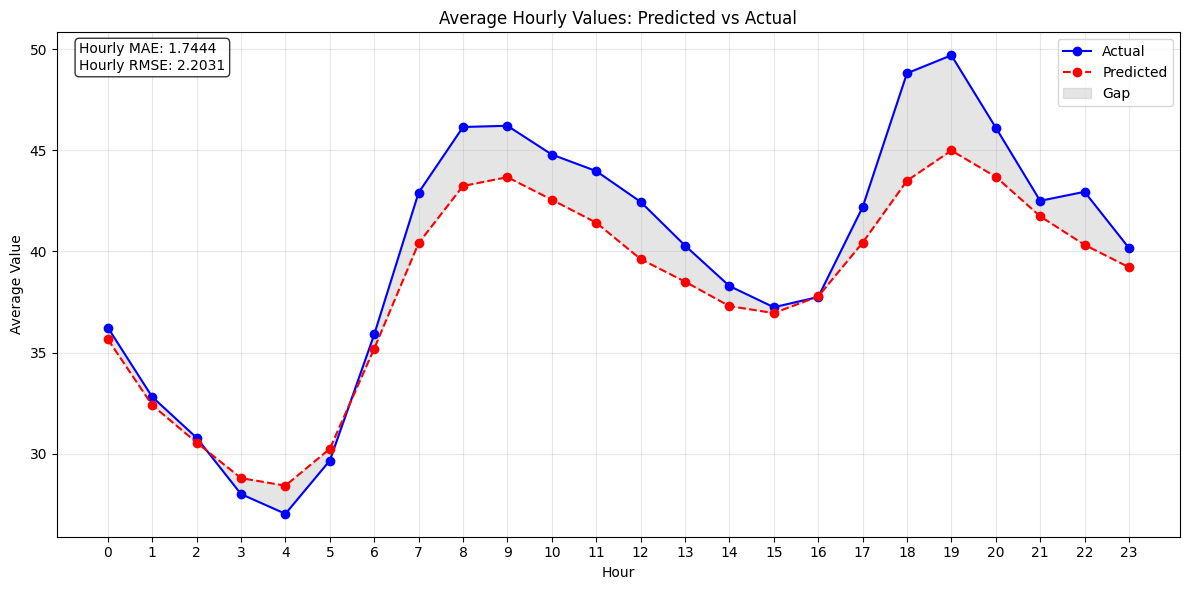

In [ ]:
pred = att_model.predict(X_past_train_transformed, X_future_train_transformed)

att_model.plot_hourly_averages(y_train, pred)